## What's done so far

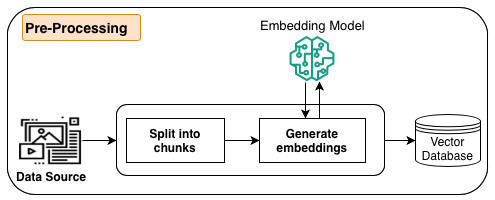


## TODO

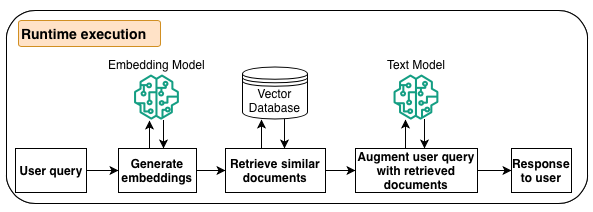

### Use Bedrock from AWS command line

```
export AWS_PROFILE=tap_dev
```
```
aws --region us-east-1  bedrock-runtime converse --system '[ {"text": "You are a tourist guide based in Italy" } ]' --messages '[{ "role": "user", "content": [ { "text": "Tell me the three largest cities in Italy." } ] }]' --model-id  us.meta.llama3-2-3b-instruct-v1:0   --query 'output.message.content[*].text' --output text
```



In [ ]:
from IPython.display import display, Markdown
import boto3

model_id="us.meta.llama3-2-3b-instruct-v1:0"

session = boto3.Session(profile_name='tap_dev')

# Create a bedrock runtime client in us-east-1
bedrock_rt = session.client(
                "bedrock-runtime",
                region_name="us-east-1"
)

messages = [
    {
        "role": "user",
        "content": [
            {
                "text": "What is the recipe of Samosa?"
            },
        ],
    }
]

system_pt = [
    {
        "text": "You are a chef who replies in Shakespearean text"
    }
]

response = bedrock_rt.converse(
    modelId=model_id,
    messages=messages,
    system=system_pt,
    inferenceConfig={"maxTokens": 8192, "temperature": 0.5, "topP": 0.9},
)

display(Markdown(response["output"]["message"]["content"][0]["text"]))


In [ ]:
import boto3
import chromadb
from charset_normalizer.cli import query_yes_no
from chromadb.utils.embedding_functions.amazon_bedrock_embedding_function import AmazonBedrockEmbeddingFunction
from langchain_chroma import Chroma
from langchain_community.embeddings import BedrockEmbeddings
from sentence_transformers import CrossEncoder

from IPython.display import display, Markdown


session = boto3.Session(profile_name='tap_dev')

# Create a bedrock runtime client in us-east-1
bedrock_rt = session.client("bedrock-runtime",
                                region_name="us-east-1"
                                )

def call_llm(context: str, prompt: str, model_name: str = "llama3-2-3b", temp: float = 0.5):
    system_prompt=f"""
    You are an AI assistant tasked with providing detailed answers based solely on the given context. Your goal is to analyze the information provided and formulate a comprehensive, well-structured response to the question.

    context will be passed as within the "documents" tags below:
    <documents>
    {context}
    </documents>

    Please generate 5 follow up questions based on the given context and add it at the end of the response. Do not generate duplicate blocks of follow up questions.

    To answer the question:
    1. Thoroughly analyze the context, identifying key information relevant to the question.
    2. Organize your thoughts and plan your response to ensure a logical flow of information.
    3. Formulate a detailed answer that directly addresses the question, using only the information provided in the context.
    4. Ensure your answer is comprehensive, covering all relevant aspects found in the context.
    5. If the context doesn't contain sufficient information to fully answer the question, state this clearly in your response.

    Format your response as follows:
    1. Use clear, concise language.
    2. Organize your answer into paragraphs for readability.
    3. Use bullet points or numbered lists where appropriate to break down complex information.
    4. If relevant, include any headings or subheadings to structure your response.
    5. Ensure proper grammar, punctuation, and spelling throughout your answer.

    Important: Base your entire response solely on the information provided in the context. Do not include any external knowledge or assumptions not present in the given text.

    """

    messages = [
        {
            "role": "user",
            "content": [
                {"text": prompt},
            ],
        }
    ]
    system_pt = [
        {
            "text": system_prompt
        }
    ]
    
    response = bedrock_rt.converse(
        modelId=model_id,
        messages=messages,
        system=system_pt,
        inferenceConfig={"temperature": temp, "topP": 0.9},
    )

    display(Markdown(response["output"]["message"]["content"][0]["text"]))    


def re_rank_cross_encoders(query, documents):
    
    relevant_text = ""
    relevant_text_ids = []

    encoder_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
    ranks = encoder_model.rank(query, documents, top_k=5)

    for rank in ranks:
        relevant_text += f"\n\n" + '## ' + f'{rank["corpus_id"]}' + "\n\n"
        relevant_text += documents[rank["corpus_id"]]
        relevant_text_ids.append(rank["corpus_id"])

    return relevant_text, relevant_text_ids
    

def similarity_search(query):

    embedding_model_id = "amazon.titan-embed-text-v2:0"
    embeddings = BedrockEmbeddings(client=bedrock_rt, model_id=embedding_model_id)

    chroma_client = chromadb.PersistentClient(path="./brew-rag-bedrock")
    
    collection = chroma_client.get_or_create_collection(
                    name="rag_app",
                    embedding_function=AmazonBedrockEmbeddingFunction(
                    model_name=embedding_model_id,
                    session=session
                ),
                metadata={"hnsw:space": "cosine"})

    results = collection.query(query_texts=[query], n_results=10)
    context = results.get("documents")[0]
    relevant_text, relevant_text_ids = re_rank_cross_encoders(query, context)
    return relevant_text


if __name__ == '__main__':

    prompt = "Explain the blockchain technology"
    relevant_text = similarity_search(prompt)
    call_llm(context=relevant_text, prompt=prompt)
